# Sample frequency simulations

## Chi-squared test and range test

We test whether each sample $1, \dots, N = {n \choose k}$ is selected with equal probability. We do two tests: the usual chi-squared test and another test based on the range of the multinomial values, $max_i n_i - min_i n_i$, where $n_1, \dots, n_N$ are the number of items in each of $N$ cells that have equal probability $1/N$.

Johnson and Young (1960) and Young (1962) provide the following approximation to the distribution of the range

$$P(\max_i n_k - \min_i n_k \leq r) \approx P(W_N \leq (r-(2B)^{-1})(N/B)^{1/2})$$

where $W_N$ denotes the sample range of $N$ independent standard normal random variables and $B$ is the number of multinomial draws. It is a known result (see e.g. Pearson and Hartley p. 43, 1954 or Ruben, 1960) that the distribution function for the range of $B$ IID normal samples is given by

$$R(w) = B \int_{-\infty}^{\infty} \phi(x)\left[ \Phi(x+w) - \Phi(x)\right]^{B-1}dx$$

where $\phi$ and $\Phi$ are the standard normal density and cumulative distribution function, respectively.  We leverage these two results to approximate the p-value of the range statistic.

## Variability across seeds

To run these tests, we generate a large number $B$ simple random samples starting at a particular seed. For any arbitrary choice of $B$ and seed, the $B$ simple random samples may or may not appear sufficiently uniformly random. What we are really interested in is how a PRNG behaves on the whole, across different seed values.

If the null hypothesis that samples occur with equal frequency is true, then the $p$-values for the chi-squared and range tests should be uniformly distributed. The $p$-value for a test starting with a particular seed may be very small and lead to rejection, but if we run the test for many different seeds, then we should only reject the test at level $\alpha$ for $100 \alpha \%$ of the seeds.

Using $B$ samples ranging from $10^5$ to $10^7$ generated from each PRNG, we run the chi-squared and range tests for 1000 different seeds. This gives us 1000 $p$-values for each test and value of $B$. Finally, we run a Kolmogorov-Smirnov test to compare the disribution of these 1000 $p$-values to a uniform distribution.

## Summary of results

We ran these tests taking samples of size $k=3$ or $k=10$ from a population of $n=13$. We used both the PIKK and sample_by_index sampling algorithms. We compared Mersenne Twister (MT), Super Duper LCG (SD), and the SHA256 PRNG.

The experiments for which the Kolmogorov-Smirnov test detected a statistically significant departure from uniformity were all of the experiments using SD and the one using MT to sample $k=10$ with PIKK. 

Across the board, the $p$-values from SD were non-uniform. They skewed to favor large $p$-values. This is especially apparent when looking at histograms of the $p$-values from the chi-squared test. The skew is less prominent for the range test.

$P$-values for MT and SHA256 tended to be uniformly distributed. The range test $p$-values tended to be closer to uniform for MT than for SHA256 (they had smaller KS statistics), but there was no systematic pattern for the chi-squared test.

In [1]:
library(dplyr)
library(ggplot2)
options(warn = (-1))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [10]:
combinations <- expand.grid(c("MT", "SD", "SHA256"),
                            c("3", "10"),
                            c("PIKK", "sbi"))

rawdatafiles <- list.files("../rawdata/")

res <- lapply(1:nrow(combinations), function(index){
  filename <- paste0(combinations[index, 1],
                     "_1000seeds_", combinations[index, 3],
                     "_n13_k", combinations[index, 2], ".csv")
  if(!(filename %in% rawdatafiles)){ return()}
  
  tmp <- read.csv(paste0("../rawdata/", filename), header = TRUE)
  tmp$PRNG <- rep(combinations[index, 1], nrow(tmp))
  tmp$algorithm <- rep(combinations[index, 3], nrow(tmp))
  return(tmp)
})
res <- do.call(rbind, res)

# KS Test of uniformity of $p$-values

Below, we compute Kolmogorov-Smirnov statistics and $p$-values for $10^7$ samples.

In [3]:
combinations <- expand.grid(c("MT", "SD", "SHA256"),
                            c(3, 10),
                            c("PIKK", "sbi"))
colnames(combinations) <- c("PRNG", "Sample size", "Algorithm")

range_pvalue_kstest <- sapply(1:nrow(combinations), function(row){
    res %>% filter(PRNG == combinations[row, 1],
                  SampleSize == combinations[row, 2],
                  algorithm == combinations[row, 3],
                  reps == 1e7) %>%
    select(rangePvalue) %>% 
    ks.test(y = punif)
    })

chisq_pvalue_kstest <- sapply(1:nrow(combinations), function(row){
    res %>% filter(PRNG == combinations[row, 1],
                  SampleSize == combinations[row, 2],
                  algorithm == combinations[row, 3],
                  reps == 1e7) %>%
    select(chisqPvalue) %>% 
    ks.test(y = punif)
    })


displ_res <- cbind(combinations, t(range_pvalue_kstest[1:2,]), t(chisq_pvalue_kstest[1:2,]))
colnames(displ_res)[4:7] <- c("Range KS Stat", "Range KS Pvalue", 
                              "Chisq KS Stat", "Chisq KS Pvalue")
displ_res %>% arrange(PRNG)

PRNG,Sample size,Algorithm,Range KS Stat,Range KS Pvalue,Chisq KS Stat,Chisq KS Pvalue
MT,3,PIKK,0.02033537,0.8026752,0.0296388,0.343387
MT,10,PIKK,0.0537681,0.00616498,0.03933686,0.0905618
MT,3,sbi,0.02177979,0.7298936,0.02467927,0.5762909
MT,10,sbi,0.02418522,0.6023116,0.03764955,0.1174159
SD,3,PIKK,0.0627056,0.0007686784,0.1676098,0
SD,10,PIKK,0.06012619,0.001448581,0.1431423,0
SD,3,sbi,0.066951,0.0002556439,0.1490059,0
SD,10,sbi,0.070318,0.0001014347,0.1129473,1.660971e-11
SHA256,3,PIKK,0.02450477,0.5854502,0.01803101,0.9011261
SHA256,10,PIKK,0.03387934,0.2011924,0.0364356,0.1405339


## P-value plots for $10^7$ samples

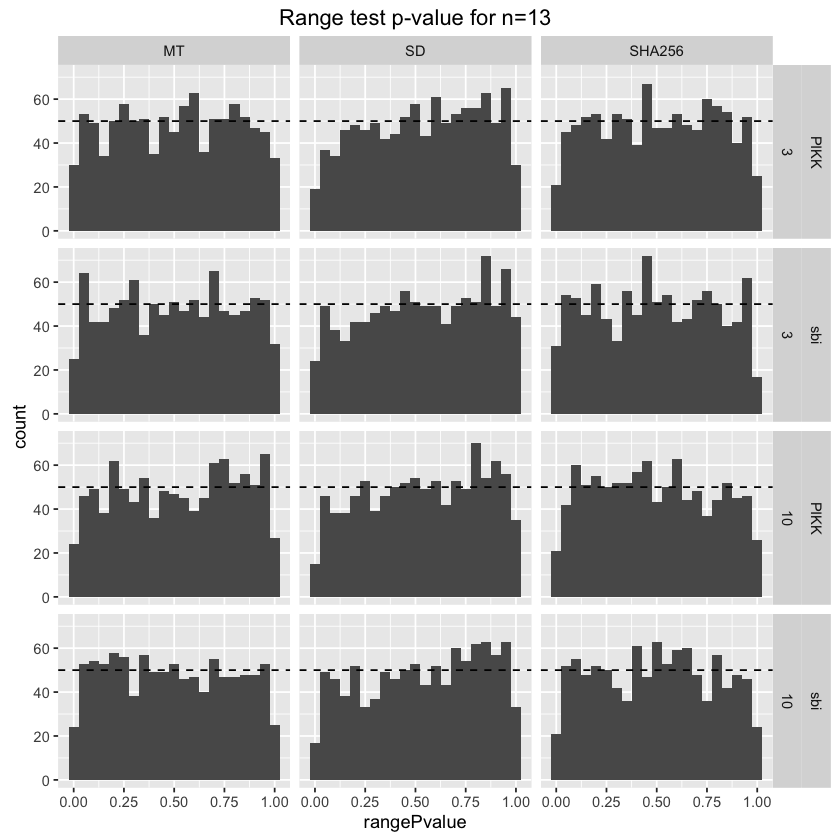

In [4]:
res %>% 
    filter(PopSize == 13) %>%
    filter(reps == 1e7) %>%
    ggplot(aes(rangePvalue)) + 
    geom_histogram(binwidth=0.05) +
    facet_grid(SampleSize+algorithm~PRNG) +
    ggtitle("Range test p-value for n=13") +
    geom_hline(yintercept = 1000*0.05, linetype = "dashed")

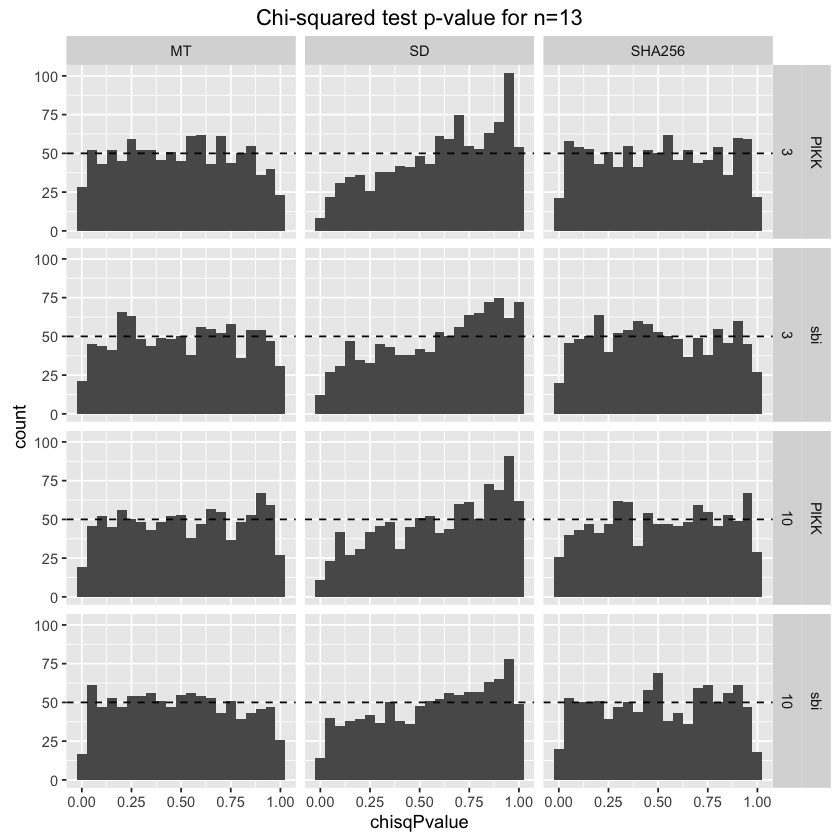

In [5]:
res %>% 
    filter(PopSize == 13) %>%
    filter(reps == 1e7) %>%
    ggplot(aes(chisqPvalue)) + 
    geom_histogram(binwidth=0.05) +
    facet_grid(SampleSize+algorithm~PRNG) +
    ggtitle("Chi-squared test p-value for n=13") +
    geom_hline(yintercept = 1000*0.05, linetype = "dashed")

# Looking at plots for all varying reps

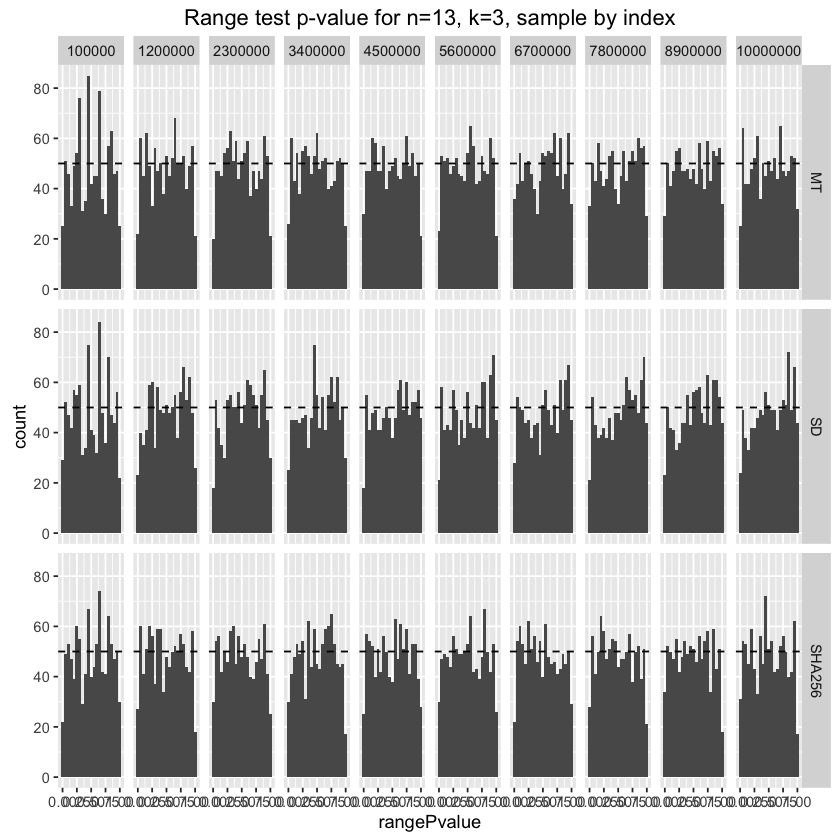

In [6]:
res %>% 
    filter(PopSize == 13, SampleSize == 3, algorithm == "sbi") %>%
    ggplot(aes(rangePvalue)) + 
    geom_histogram(binwidth = 0.05) +
    facet_grid(PRNG~reps) +
    ggtitle("Range test p-value for n=13, k=3, sample by index") +
    geom_hline(yintercept = 0.05*1000, linetype = "dashed")

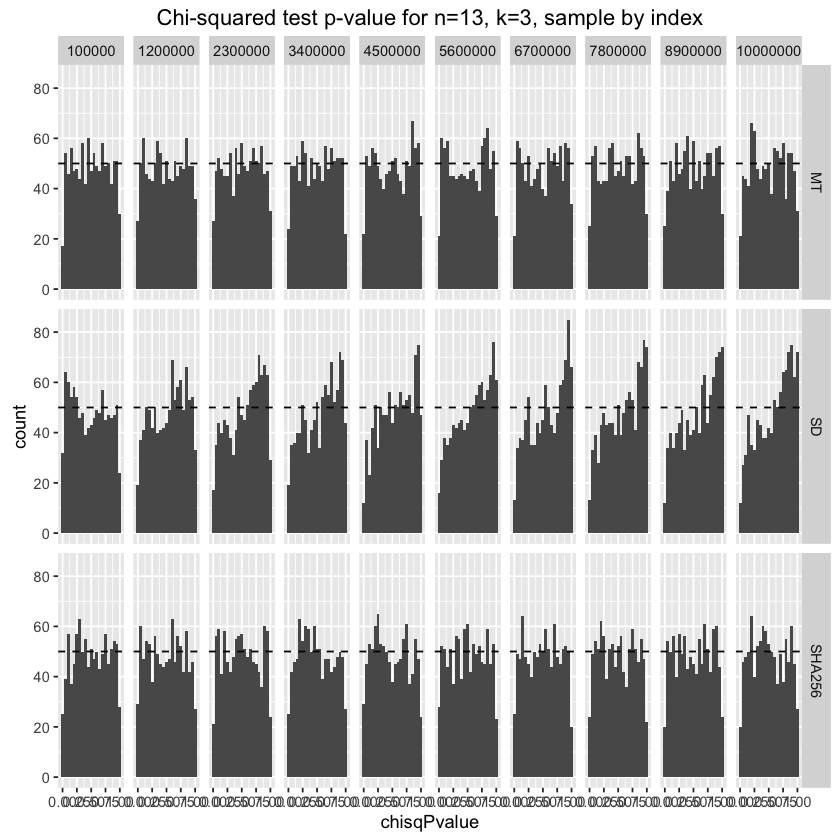

In [7]:
res %>% 
    filter(PopSize == 13, SampleSize == 3, algorithm == "sbi") %>%
    ggplot(aes(chisqPvalue)) + 
    geom_histogram(binwidth = 0.05) +
    facet_grid(PRNG~reps) +
    ggtitle("Chi-squared test p-value for n=13, k=3, sample by index")  +
    geom_hline(yintercept = 0.05*1000, linetype = "dashed")

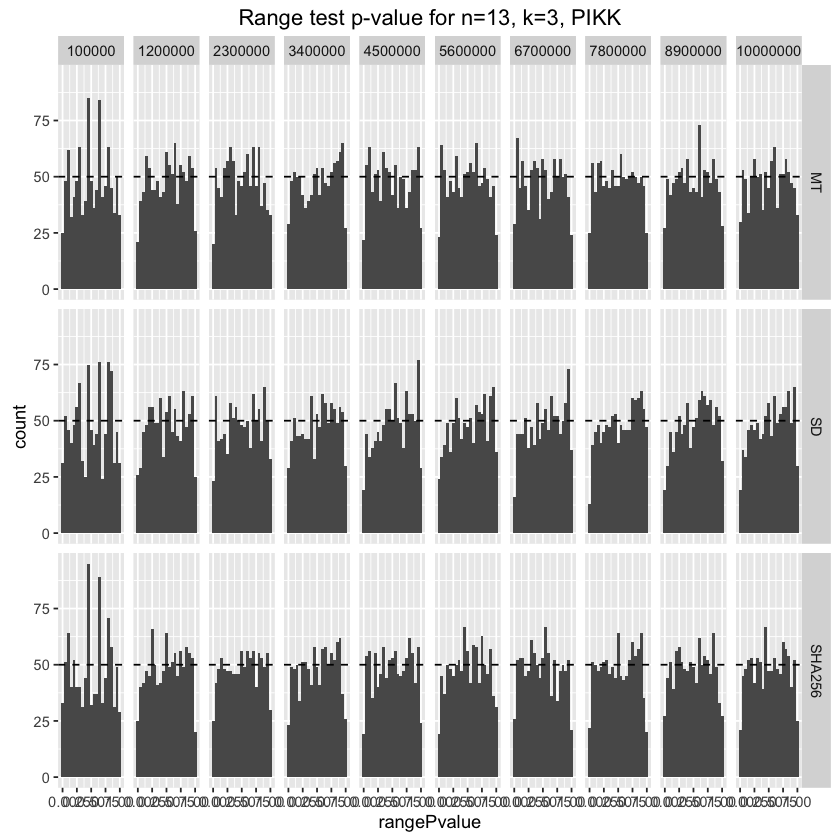

In [8]:
res %>% 
    filter(PopSize == 13, SampleSize == 3, algorithm == "PIKK") %>%
    ggplot(aes(rangePvalue)) + 
    geom_histogram(binwidth = 0.05) +
    facet_grid(PRNG~reps) +
    ggtitle("Range test p-value for n=13, k=3, PIKK")  +
    geom_hline(yintercept = 0.05*1000, linetype = "dashed")

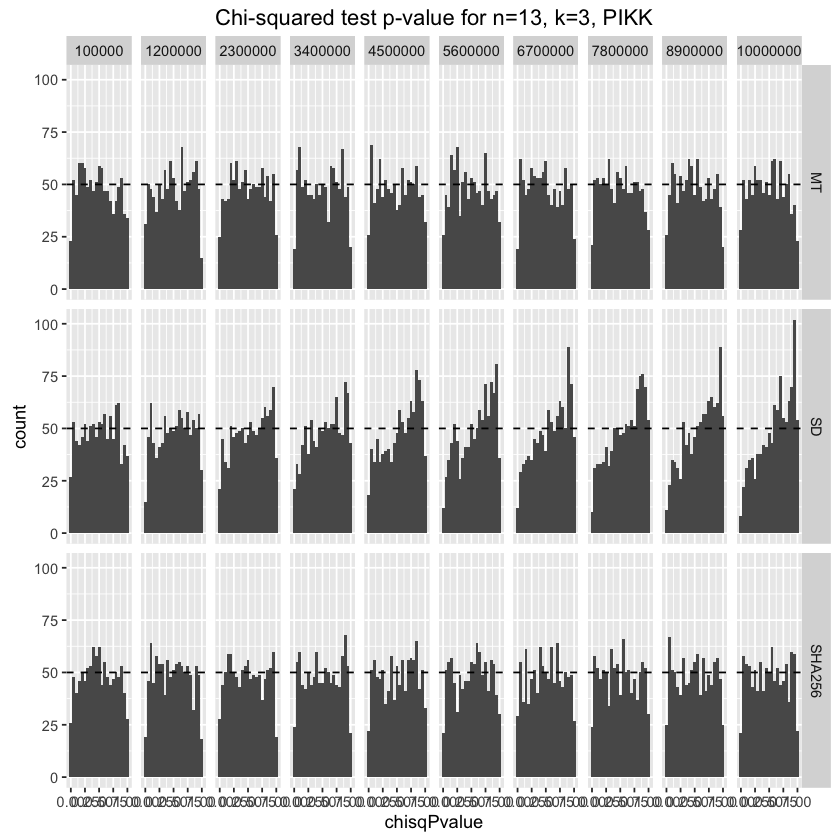

In [9]:
res %>% 
    filter(PopSize == 13, SampleSize == 3, algorithm == "PIKK") %>%
    ggplot(aes(chisqPvalue)) + 
    geom_histogram(binwidth = 0.05) +
    facet_grid(PRNG~reps) +
    ggtitle("Chi-squared test p-value for n=13, k=3, PIKK")  +
    geom_hline(yintercept = 0.05*1000, linetype = "dashed")